# Classificação Iris

In [37]:
# PARÂMETROS
random_seed = 42
my_class = 'versicolor' # setosa, virginica, versicolor

# FEATURE SELECTION
center_stat = 'median'
select_by_center_stat = True
x_cols = ['petal_length', 'petal_width']

# KNN
k = 11
distance_metric = 'minkowski' # euclidean, manhattan, chebyshev, minkowski
weights = 'uniform'
test_size = 0.2
change_operation_point = False

In [38]:
import numpy
import pandas
import seaborn
from matplotlib import pyplot
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### PRÉ-PROCESSAMENTO

In [39]:
iris_dict = load_iris()
iris = pandas.DataFrame.from_dict(iris_dict['data'])
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris.columns = iris_dict['feature_names']
iris['species'] = iris_dict['target']
iris['species'] = iris['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
iris.columns = column_names
iris['y'] = (iris.species == my_class).astype(float)
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0.0
1,4.9,3.0,1.4,0.2,setosa,0.0
2,4.7,3.2,1.3,0.2,setosa,0.0
3,4.6,3.1,1.5,0.2,setosa,0.0
4,5.0,3.6,1.4,0.2,setosa,0.0
5,5.4,3.9,1.7,0.4,setosa,0.0
6,4.6,3.4,1.4,0.3,setosa,0.0
7,5.0,3.4,1.5,0.2,setosa,0.0
8,4.4,2.9,1.4,0.2,setosa,0.0
9,4.9,3.1,1.5,0.1,setosa,0.0


In [40]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width,y
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,0.333333
std,0.828066,0.435866,1.765298,0.762238,0.472984
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,0.000000
75%,6.400000,3.300000,5.100000,1.800000,1.000000
max,7.900000,4.400000,6.900000,2.500000,1.000000


### BALANÇO DE CLASSES

In [41]:
100.0*iris.y.value_counts(normalize=True)

y
0.0    66.666667
1.0    33.333333
Name: proportion, dtype: float64

### PairPlots

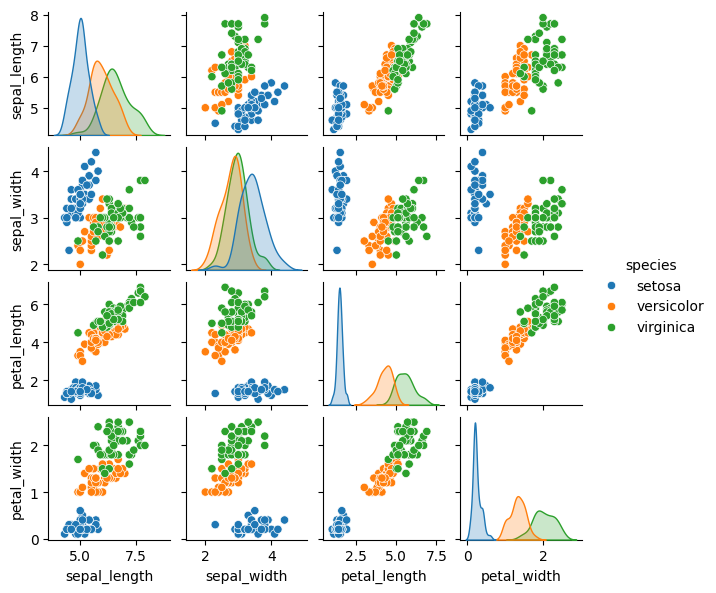

In [42]:
_ = seaborn.pairplot(iris[column_names], hue='species', height=1.5)

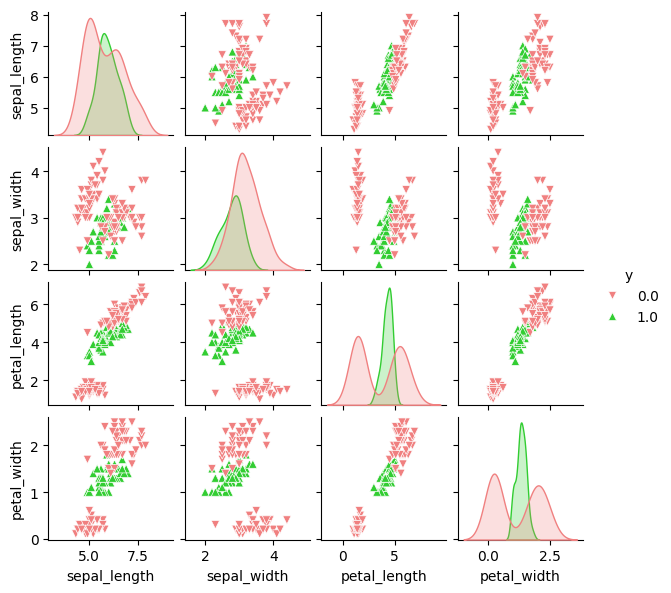

In [43]:
_ = seaborn.pairplot(iris, hue='y', height=1.5, palette={0: 'lightcoral', 1: 'limegreen'}, markers=['v', '^'])

### BOXPLOTS VARIAVEIS VS CLASSE

In [44]:
all_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
centers = iris.groupby(['y'])[all_cols].agg(center_stat).T
centers['diff'] = abs(centers[1] - centers[0])
centers = centers.sort_values('diff', ascending=False)

centers

y,0.0,1.0,diff
petal_length,3.2,4.35,1.15
sepal_width,3.2,2.80,0.40
petal_width,1.0,1.30,0.30
sepal_length,5.7,5.90,0.20


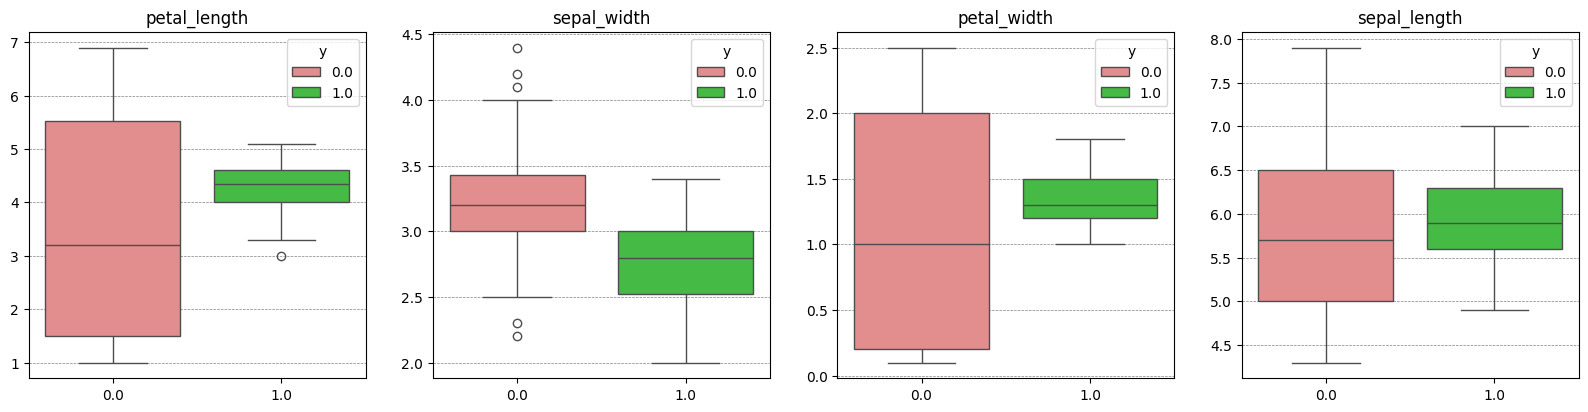

In [45]:
x_cols_sorted = centers['diff'].sort_values(ascending=False).index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs.flatten()):
    seaborn.boxplot(x='y', y=x_cols_sorted[i], data=iris, ax=ax, hue='y', dodge=False, palette=['lightcoral', 'limegreen'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(x_cols_sorted[i])
    ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

### Classificador - K Vizinhos mais Próximos


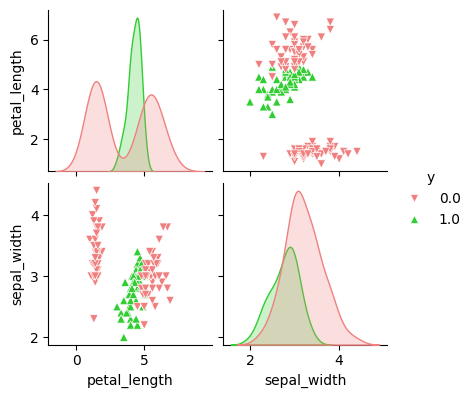

In [46]:
if select_by_center_stat:
    model_cols = x_cols_sorted[:2]
else:
    model_cols = x_cols

_ = seaborn.pairplot(iris[model_cols + ['y']], hue='y', height=2.0, palette={0: 'lightcoral', 1: 'limegreen'}, markers=['v', '^'])

In [47]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)

# SPLIT THE DATASET INTO TRAINING AND TESTING SETS
X = iris[model_cols].to_numpy()
y = iris['y'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_seed)

# STANDARDIZE THE DATA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# TRAIN THE MODEL
knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric, n_jobs=-1, weights=weights)
knn.fit(X_train_scaled, y_train)

# CALCULATE TEST ACCURACY
y_pred = knn.predict(X_test_scaled)
train_accuracy = knn.score(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train accuracy: {100.0*train_accuracy:.2f}%\nTest accuracy: {100.0*accuracy:.2f}%')

Train accuracy: 91.67%
Test accuracy: 86.67%


### VISUALIZAR SEPARADOR, MATRIZ DE CONFUSÃO E ROC

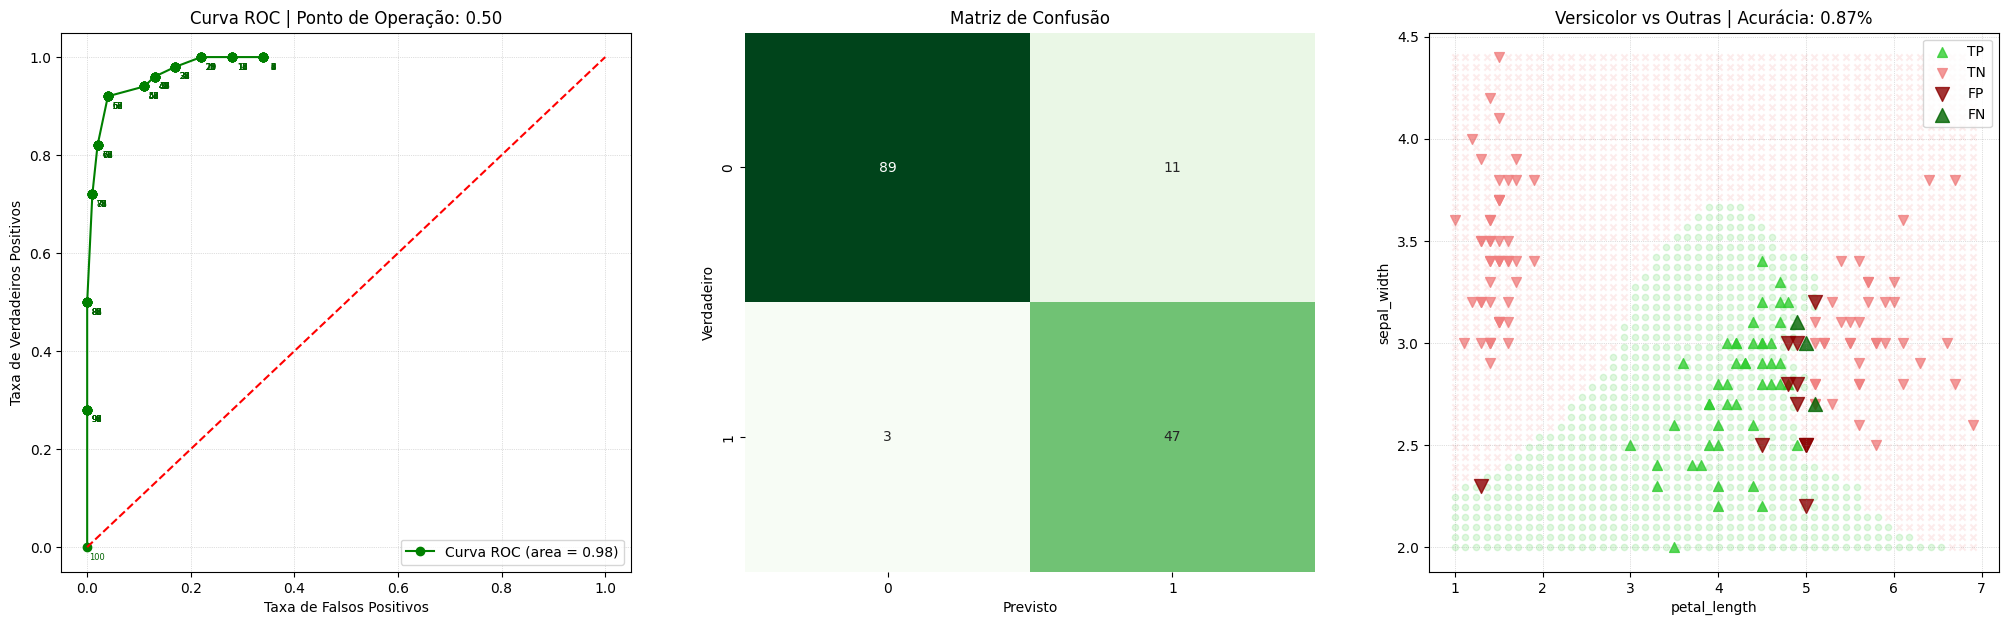

In [48]:
x_col = model_cols[0]
y_col = model_cols[1]

linspace_points = 50
roc_thresholds = 100

y_pred_proba = knn.predict_proba(X_scaled)[:,1]    
proba_linspace = numpy.linspace(0, 1, roc_thresholds)

roc_points = []
for i, threshold in enumerate(proba_linspace):
    y_pred = (y_pred_proba > threshold).astype(float)
    tp = numpy.sum((y == 1) & (y_pred == 1))
    tn = numpy.sum((y == 0) & (y_pred == 0))
    fp = numpy.sum((y == 0) & (y_pred == 1))
    fn = numpy.sum((y == 1) & (y_pred == 0))
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    roc_points.append((threshold, fpr, tpr))

if change_operation_point:
    best_operation_point = max(roc_points, key=lambda x: x[2] - x[1])
else:
    best_operation_point = (0.5, 0.5, 0.5)
    
y_pred_operation = (y_pred_proba > best_operation_point[0]).astype(float)

fig = pyplot.figure(figsize=(25, 7))
# PLOT AND ANNOTATE ROC CURVE
ax = fig.add_subplot(131)
_ = ax.plot([x[1] for x in roc_points], [x[2] for x in roc_points], color='green', label=f'Curva ROC (area = {roc_auc_score(y, y_pred_proba):.2f})', marker='o')
_ = ax.plot([0, 1], [0, 1], color='red', linestyle='--')
_ = ax.set_xlabel('Taxa de Falsos Positivos')
_ = ax.set_ylabel('Taxa de Verdadeiros Positivos')
_ = ax.set_title(f'Curva ROC | Ponto de Operação: {best_operation_point[0]:.2f}')
_ = ax.legend()
_ = ax.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
# ANNOTATE ROC CURVE
for i, threshold in enumerate(proba_linspace):
    ax.annotate(f'{100.0*threshold:.0f}', (roc_points[i][1], roc_points[i][2]), textcoords='offset points', xytext=(7, -7), ha='center', va='center', fontsize=6, color='darkgreen')

# PLOT CONFUSION MATRIX
conf_matrix = confusion_matrix(y, y_pred_operation)

ax = fig.add_subplot(132)
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, ax=ax)
_ = ax.set_xlabel('Previsto')
_ = ax.set_ylabel('Verdadeiro')
_ = ax.set_title('Matriz de Confusão')

class_areas_list = []
linspace_point_list = []
for x_i in numpy.linspace(iris[x_col].min(),iris[x_col].max(), linspace_points):
    for y_i in numpy.linspace(iris[y_col].min(),iris[y_col].max(), linspace_points):
        p_i = knn.predict_proba(scaler.transform([[x_i, y_i]]))[0][1]
        if p_i > best_operation_point[0]:
            c_i = 1
        else:
            c_i = 0

        class_areas_list.append({'x': x_i, 'y': y_i, 'c': c_i, 'p': p_i})

class_areas_df = pandas.DataFrame(class_areas_list)
ax = fig.add_subplot(133)
_ = class_areas_df[class_areas_df['c'] == 0].plot.scatter(x='x', y='y', color='lightcoral', ax=ax, alpha=0.15, marker='x')
_ = class_areas_df[class_areas_df['c'] == 1].plot.scatter(x='x', y='y', color='limegreen', ax=ax, alpha=0.15, marker='o')

# PLOT TRUE POSITIVES
_ = iris[(iris['y'] == 1.0) & (y_pred_operation == 1.0)].plot.scatter(x=x_col,y=y_col, color='limegreen', label='TP', ax=ax, s=50, alpha=0.8, marker='^')
# PLOT TRUE NEGATIVES
_ = iris[(iris['y'] == 0.0) & (y_pred_operation == 0.0)].plot.scatter(x=x_col,y=y_col, color='lightcoral', label='TN', ax=ax, s=50, marker='v', alpha=0.8)
# PLOT FALSE POSITIVES
_ = iris[(iris['y'] == 0.0) & (y_pred_operation == 1.0)].plot.scatter(x=x_col,y=y_col, color='darkred', label='FP', ax=ax, s=100, alpha=0.8, marker='v')
# PLOT FALSE NEGATIVES
_ = iris[(iris['y'] == 1.0) & (y_pred_operation == 0.0)].plot.scatter(x=x_col,y=y_col, color='darkgreen', label='FN', ax=ax, s=100, alpha=0.8, marker='^')
_ = ax.set_title(f"{my_class.capitalize()} vs Outras | Acurácia: {accuracy:.2f}%")
_ = ax.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)